In [321]:
import pandas as pd;
import numpy as np;
import scipy as sp;
import sklearn;
import sys;
from nltk.corpus import stopwords;
import nltk;
from gensim.models import ldamodel
import gensim.corpora;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
from sklearn.decomposition import TruncatedSVD
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
import pickle;
import utilities

utils = utilities.Utils()



pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [78]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import random 
random.seed(13)

#visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import seaborn as sns


In [3]:
import csv
import re
#import spacy
import sys
import requests
import pandas as pd
from io import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
import os
import sys, getopt
import numpy as np
from bs4 import BeautifulSoup
import urllib3
from glob import glob
from string import punctuation

from nltk.corpus import wordnet

def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

def find_pdfs():
    list_of_pdfs = []
    list_of_pdfs += glob(os.path.join('./LosPositasSyllabi',"*.{}".format('pdf')))
    list_of_pdfs += glob(os.path.join('./LosPositasSyllabi2',"*.{}".format('pdf')))
    list_of_pdfs += glob(os.path.join('./LosPositasSyllabi3',"*.{}".format('pdf')))
    list_of_pdfs += glob(os.path.join('./LosPositasSyllabi4',"*.{}".format('pdf')))
    list_of_pdfs += glob(os.path.join('./AllSyllabiParser',"*.{}".format('pdf')))
    return list_of_pdfs

def convert(fname, pages=None):
    """ Function converting pdf to string """
    if not pages:
        pagenums = set()
    else:
        pagenums = set(pages)

    output = StringIO()
    manager = PDFResourceManager()
    converter = TextConverter(manager, output, laparams=LAParams())
    interpreter = PDFPageInterpreter(manager, converter)

    infile = open(fname, 'rb')
    
    try:
        for page in PDFPage.get_pages(infile, pagenums):
            interpreter.process_page(page)
    except PDFTextExtractionNotAllowed:
        print('This pdf won\'t allow text extraction!')
    infile.close()
    converter.close()
    text = output.getvalue()
    output.close
    return strip_punctuation(text)

def word_count(string):
    my_string = string.lower().split()
    my_dict = {}
    for item in my_string:
        if item in my_dict:
            my_dict[item] += 1
        else:
            my_dict[item] = 1
    


In [4]:
list_of_pdfs = find_pdfs()
syllabus_string = ''
bag_of_words_all_syllabi = []
corpus = []
#Converting pdf to string
for pdf in list_of_pdfs:
    syllabus_string = convert(pdf)
    corpus.append(syllabus_string)
#     bag_of_words_one_syllabus = word_count(syllabus_string)
#     bag_of_words_all_syllabi.append(bag_of_words_one_syllabus)

This pdf won't allow text extraction!
This pdf won't allow text extraction!


**Text Cleaning**

In [5]:
from nltk.corpus import words
from nltk.corpus import stopwords
 

allEnglishWords = set(words.words())
stopwordsList = set(stopwords.words('english'))

def clean_doc(doc, english = False, return_list = False, stopwords = False):
    listOfWords = re.findall(r'[^\d\W]{2,}', doc)
    listOfWords = [word.lower() for word in listOfWords]
    if english:
        listOfWords = [word for word in listOfWords if word in allEnglishWords]
    if stopwords:
        listOfWords = [word for word in listOfWords if word not in stopwordsList]
    if return_list:
        return listOfWords
    else:
        return " ".join(listOfWords)


In [6]:
cleaned_corpus = [clean_doc(doc, return_list = True, stopwords = True) for doc in corpus]

In [7]:
cleaned_corpus_1 = [clean_doc(doc, english = True, return_list = True, stopwords = True) for doc in corpus]

In [8]:
cleaned_corpus_2 = [clean_doc(doc, english = True, return_list = False, stopwords = True) for doc in corpus]

In [9]:
cleaned_corpus_3 = [clean_doc(doc, english = False, return_list = False, stopwords = True) for doc in corpus]

In [10]:
cleaned_corpus_4 = [clean_doc(doc, english = False, return_list = True, stopwords = True) for doc in corpus]

**NMF**

In [467]:
vectorizer = CountVectorizer(analyzer='word', stop_words='english', lowercase=True, token_pattern=r'[^\d\W]{2,}', ngram_range = (1,1), max_df = 0.9);
x_counts = vectorizer.fit_transform(cleaned_corpus_2);

In [468]:
id2word = {}
for i, word in enumerate(words):
    id2word[i] = word

In [469]:
transformer = TfidfTransformer(smooth_idf=True);
x_tfidf = transformer.fit_transform(x_counts);

In [470]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [471]:
def get_nmf_topics(model, num_topics, top_n_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-top_n_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [534]:
num_topics = 16
nmf_model = NMF(n_components=num_topics, init='nndsvd')
nmf_model.fit(xtfidf_norm)
nmf_embedding = nmf_model.transform(xtfidf_norm)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

In [473]:
get_nmf_topics(nmf_model, num_topics,5)

Topic # 01   Topic # 02 Topic # 03     Topic # 04 Topic # 05   Topic # 06 Topic # 07   Topic # 08   Topic # 09       Topic # 10 Topic # 11 Topic # 12 Topic # 13  Topic # 14 Topic # 15  Topic # 16     Topic # 17  Topic # 18   Topic # 19 Topic # 20  Topic # 21 Topic # 22   Topic # 23 Topic # 24   Topic # 25
0        writing      missing     soccer          dance    welding  independent    fitness      theater         math       basketball     design    network       wine    swimming   painting       music           flag  automotive         yoga  badminton  experience      baton       health        web    amplifier
1  communication  interactive       play           jazz        arc      project   exercise      musical       linear  intercollegiate  landscape  configure     winery        polo      color        jazz       football      safety   relaxation   backhand        work   deletion        child       site      missing
2        reading          lab    outdoor         ballet    cutting        study   training   production      algebra             game   lighting      cisco      grape        swim        art       piano           game         lab    breathing   forehand         job      legal    childhood     create  operational
3          group   transistor       game       movement      metal          end  endurance       acting        solve             team    drawing    routing    tasting       water     studio      guitar       catching     control     strength   ultimate      career     weapon         care     office          lab
4       research      digital    heading  choreographic       pipe        noted   strength  performance  exponential         shooting      plant   security   vineyard  backstroke   critique  literature  participation  diagnostic  flexibility    singles  supervisor    officer  development       data     computer

In [180]:
get_nmf_topics(nmf_model, num_topics,5)

Topic # 01 Topic # 02 Topic # 03     Topic # 04   Topic # 05   Topic # 06 Topic # 07   Topic # 08 Topic # 09  Topic # 10    Topic # 11     Topic # 12 Topic # 13  Topic # 14 Topic # 15 Topic # 16     Topic # 17  Topic # 18  Topic # 19 Topic # 20       Topic # 21   Topic # 22  Topic # 23 Topic # 24    Topic # 25 Topic # 26 Topic # 27 Topic # 28 Topic # 29    Topic # 30  Topic # 31 Topic # 32 Topic # 33  Topic # 34   Topic # 35   Topic # 36     Topic # 37 Topic # 38  Topic # 39     Topic # 40 Topic # 41     Topic # 42    Topic # 43  Topic # 44       Topic # 45 Topic # 46 Topic # 47    Topic # 48   Topic # 49 Topic # 50    Topic # 51 Topic # 52 Topic # 53 Topic # 54      Topic # 55 Topic # 56 Topic # 57 Topic # 58   Topic # 59 Topic # 60 Topic # 61 Topic # 62 Topic # 63    Topic # 64   Topic # 65 Topic # 66  Topic # 67    Topic # 68    Topic # 69   Topic # 70  Topic # 71 Topic # 72  Topic # 73   Topic # 74  Topic # 75   Topic # 76    Topic # 77     Topic # 78 Topic # 79 Topic # 80  \
0      business     soccer    welding          dance      missing  independent   training  exponential    musical  basketball       digital        network       wine    swimming   painting   exercise           flag        yoga  automotive  badminton        childhood       design  experience   criminal         plant    grammar    bowling    fencing     indoor          math        polo   ceremony      baton  volleyball     lighting         jazz          child   ultimate  accounting  communication        web          cisco        safety     theater  intercollegiate      color     sports         piano      drawing   geologic       library    medical     health  configure            film     energy        gun     lesson       acting     guitar     longer       judo    walking           art  engineering     sexual   newspaper     landscape          drug     vineyard     biology   softball      linear     juvenile         tae       winery   photography         public    writing      excel   
1     marketing       play        arc         ballet      outline      project     weight  logarithmic    theater        game         image       security      grape        swim     studio    fitness       football          yo  diagnostic   backhand            early     interior        work      crime        garden       verb       game   footwork   climbing       algebra       water  anthology   deletion        team        light   literature    development   forehand        cash  interpersonal       site        routing    protection  production      competition        hue      sport      teaching       figure    geology        search    patient     safety     server          cinema    physics      rifle    choking    character    classic     taught    martial    fitness         works      optical     gender       story  construction      pharmacy   irrigation  laboratory    batting       solve      justice  federation         wine  photographic      marketing    reading       word   
2        market    outdoor    cutting       movement       course        study   strength     rational       duet    shooting        camera       wireless    tasting  backstroke      color  endurance       catching   breathing      engine    singles       curriculum       client  supervisor    justice  horticulture       past       step      blade       rock      learning     offense   literary     weapon       serve       design     ensemble         family   backhand     payroll       conflict       page  configuration     emergency  theatrical             team     colors   athletic  intermediate  composition      earth  bibliography       word       care  directory       narrative     motion     patrol      adult        scene      music     course    jujitsu     attire  architecture       optics  sexuality  journalism          site  pharmacology         soil        cell       slow        math  delinquency      proper       cellar       century    advertising   sentence     office   
3    

**Visualize using T-SNE**

In [535]:
tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)

In [536]:
def center(points, d = 2):
    if len(points) == 0: return None
    elif d==2:
        return (sum([x[0] for x in points])/len(points), sum([x[1] for x in points])/len(points))
    elif d==3:
        return (sum([x[0] for x in points])/len(points), sum([x[1] for x in points])/len(points), sum([x[2] for x in points])/len(points))

In [537]:
tsne_groups = [[] for x in range(num_topics)] 
for i in range(len(tsne_embedding)):
    tsne_groups[tsne_embedding['hue'][i]].append((tsne_embedding['x'][i],tsne_embedding['y'][i]))
tsne_centers = [center(points) for points in tsne_groups]

In [541]:
def top_n_words(n):
    topic_words = [None]*num_topics
    wordsDf = get_nmf_topics(nmf_model, num_topics,n)
    for i in range(num_topics):
        topic_words[i] = '\n '.join(wordsDf.iloc[0:n, i])
    return topic_words

topic_words = top_n_words(3)
topic_words

['communication\n research\n writing',
 'missing\n interactive\n lab',
 'soccer\n play\n outdoor',
 'dance\n jazz\n ballet',
 'welding\n arc\n cutting',
 'independent\n project\n study',
 'fitness\n exercise\n training',
 'theater\n musical\n music',
 'math\n linear\n algebra',
 'basketball\n game\n intercollegiate',
 'web\n design\n create',
 'network\n configure\n cisco',
 'wine\n winery\n grape',
 'swimming\n polo\n swim',
 'painting\n color\n art',
 'yoga\n relaxation\n breathing']

In [545]:
font = {'family' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

<IPython.core.display.Javascript object>


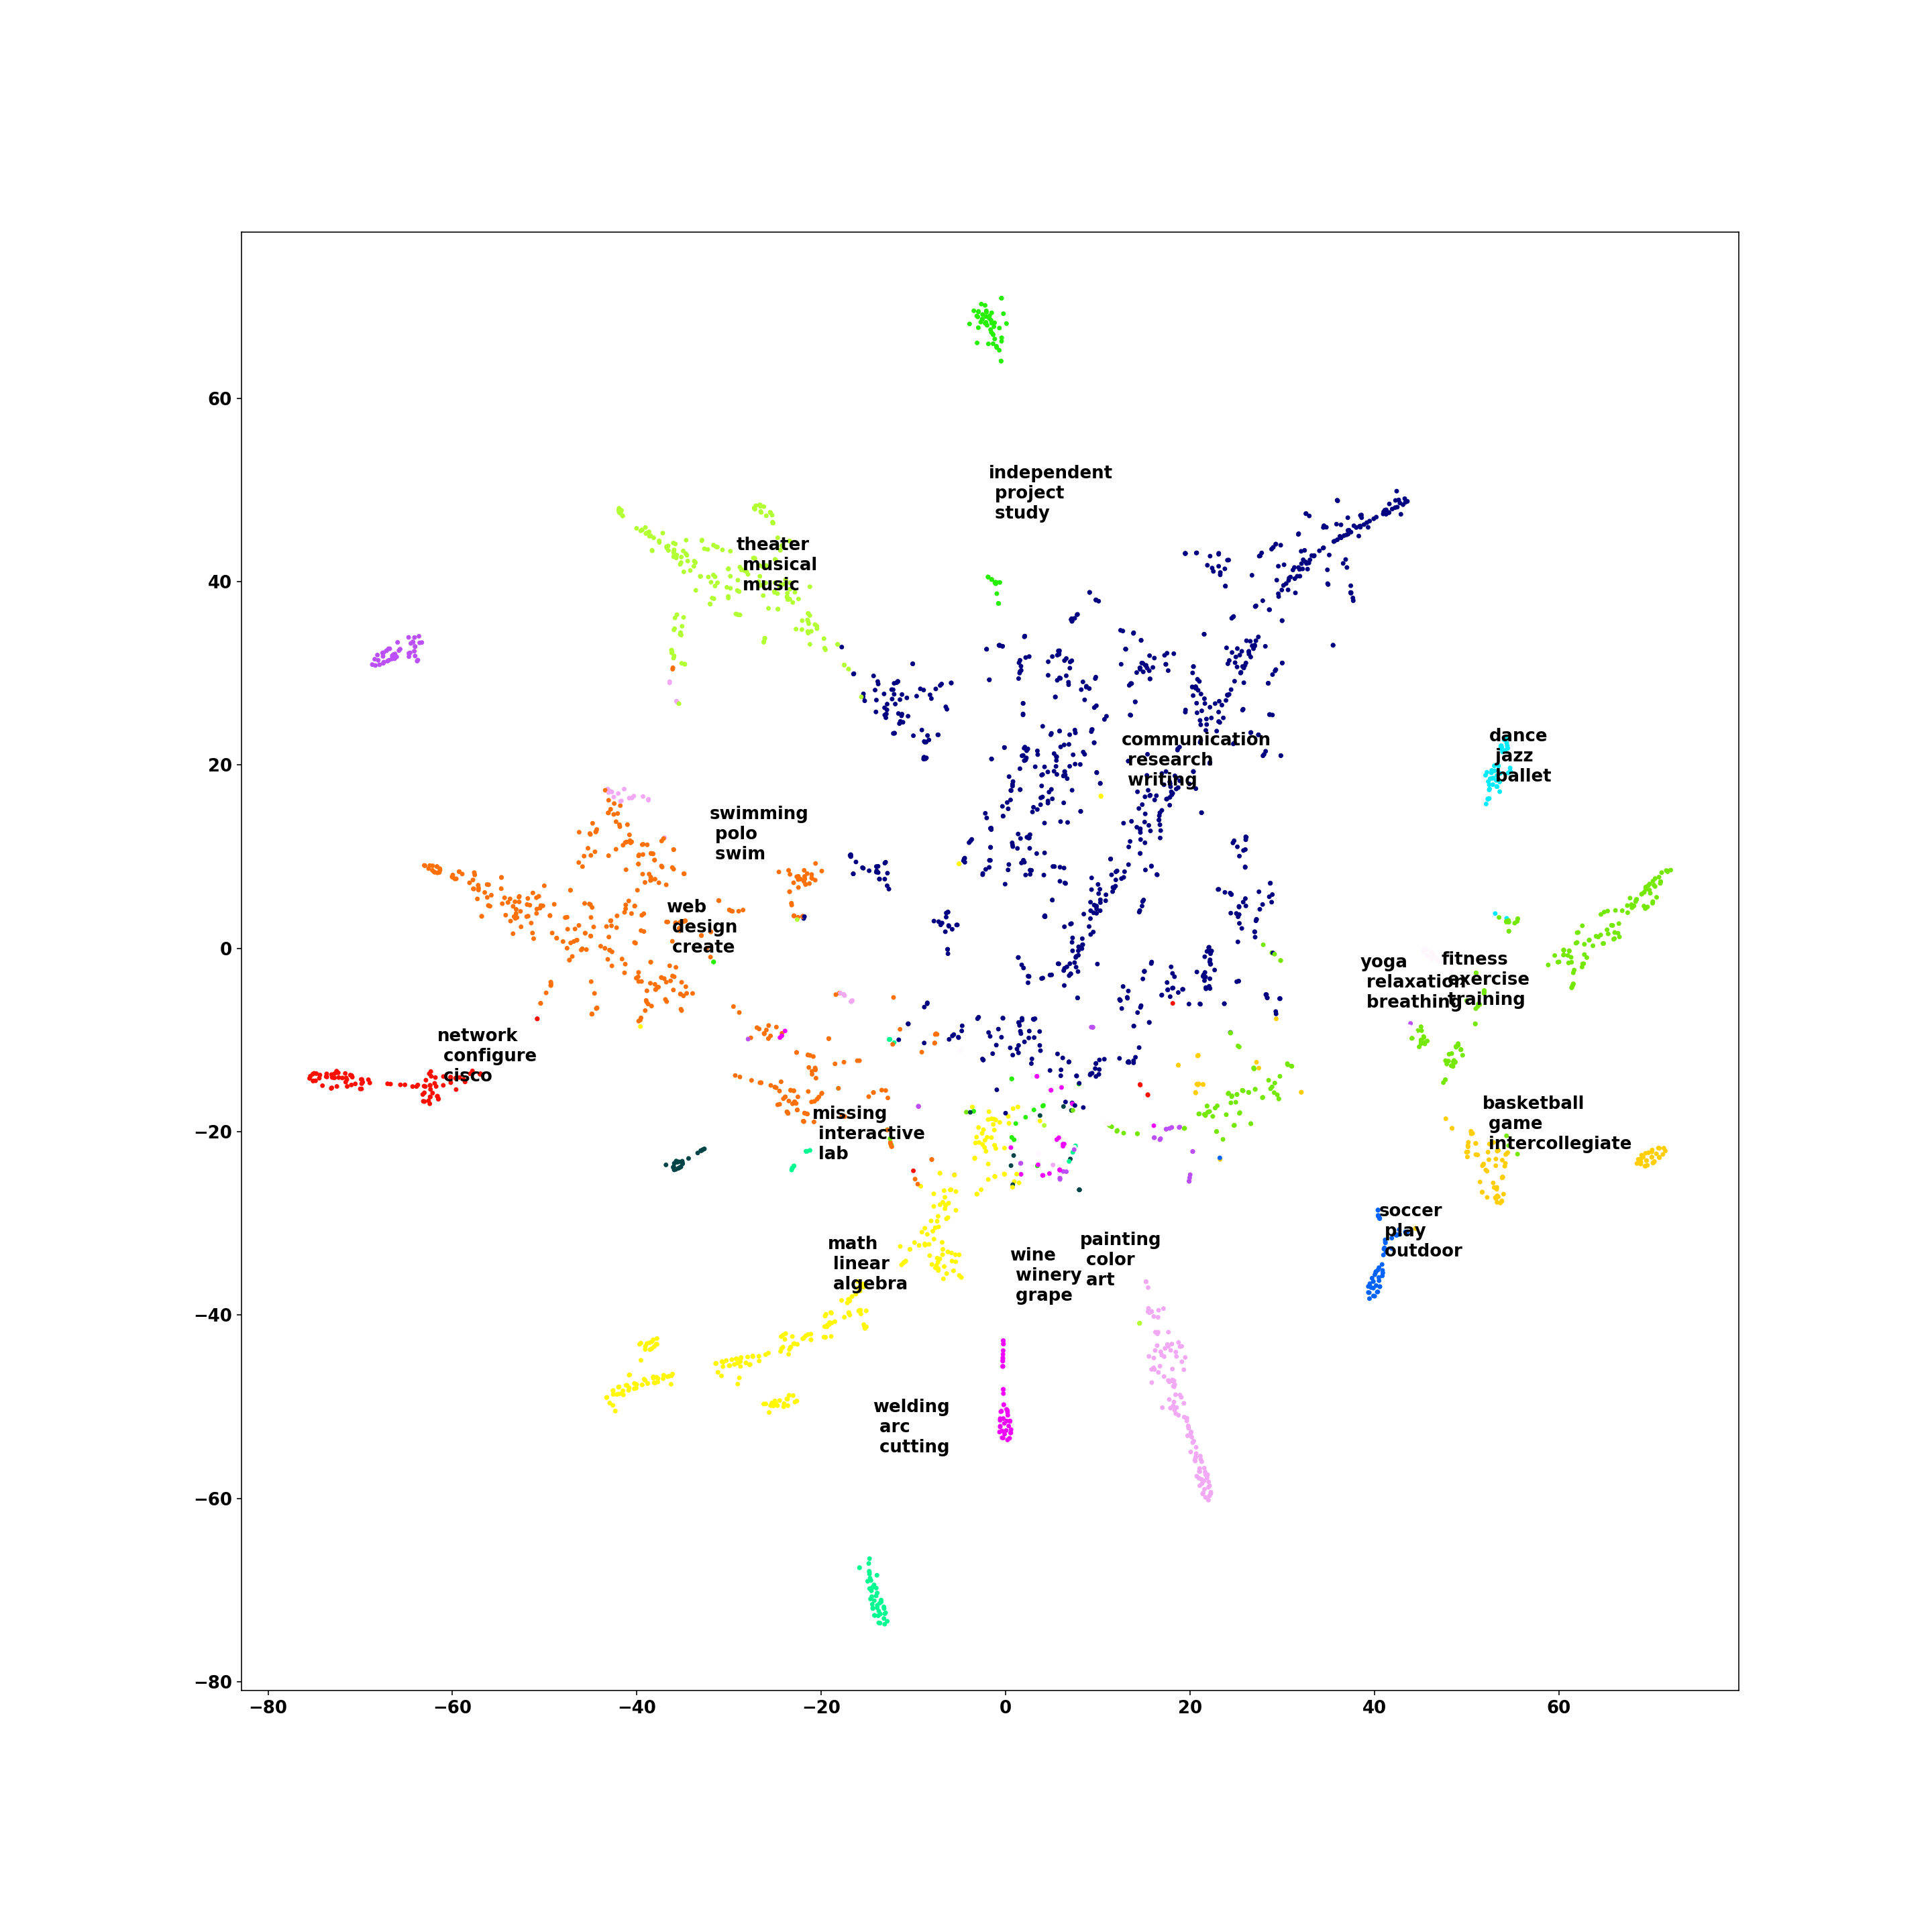

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop

In [546]:
fig = plt.figure(figsize=(20, 20))
data = tsne_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="gist_ncar")
for i, words in enumerate(topic_words):
    plt.annotate(words, (tsne_centers[i][0], tsne_centers[i][1]))
plt.show()
plt.savefig("nmf_25.png")

<IPython.core.display.Javascript object>


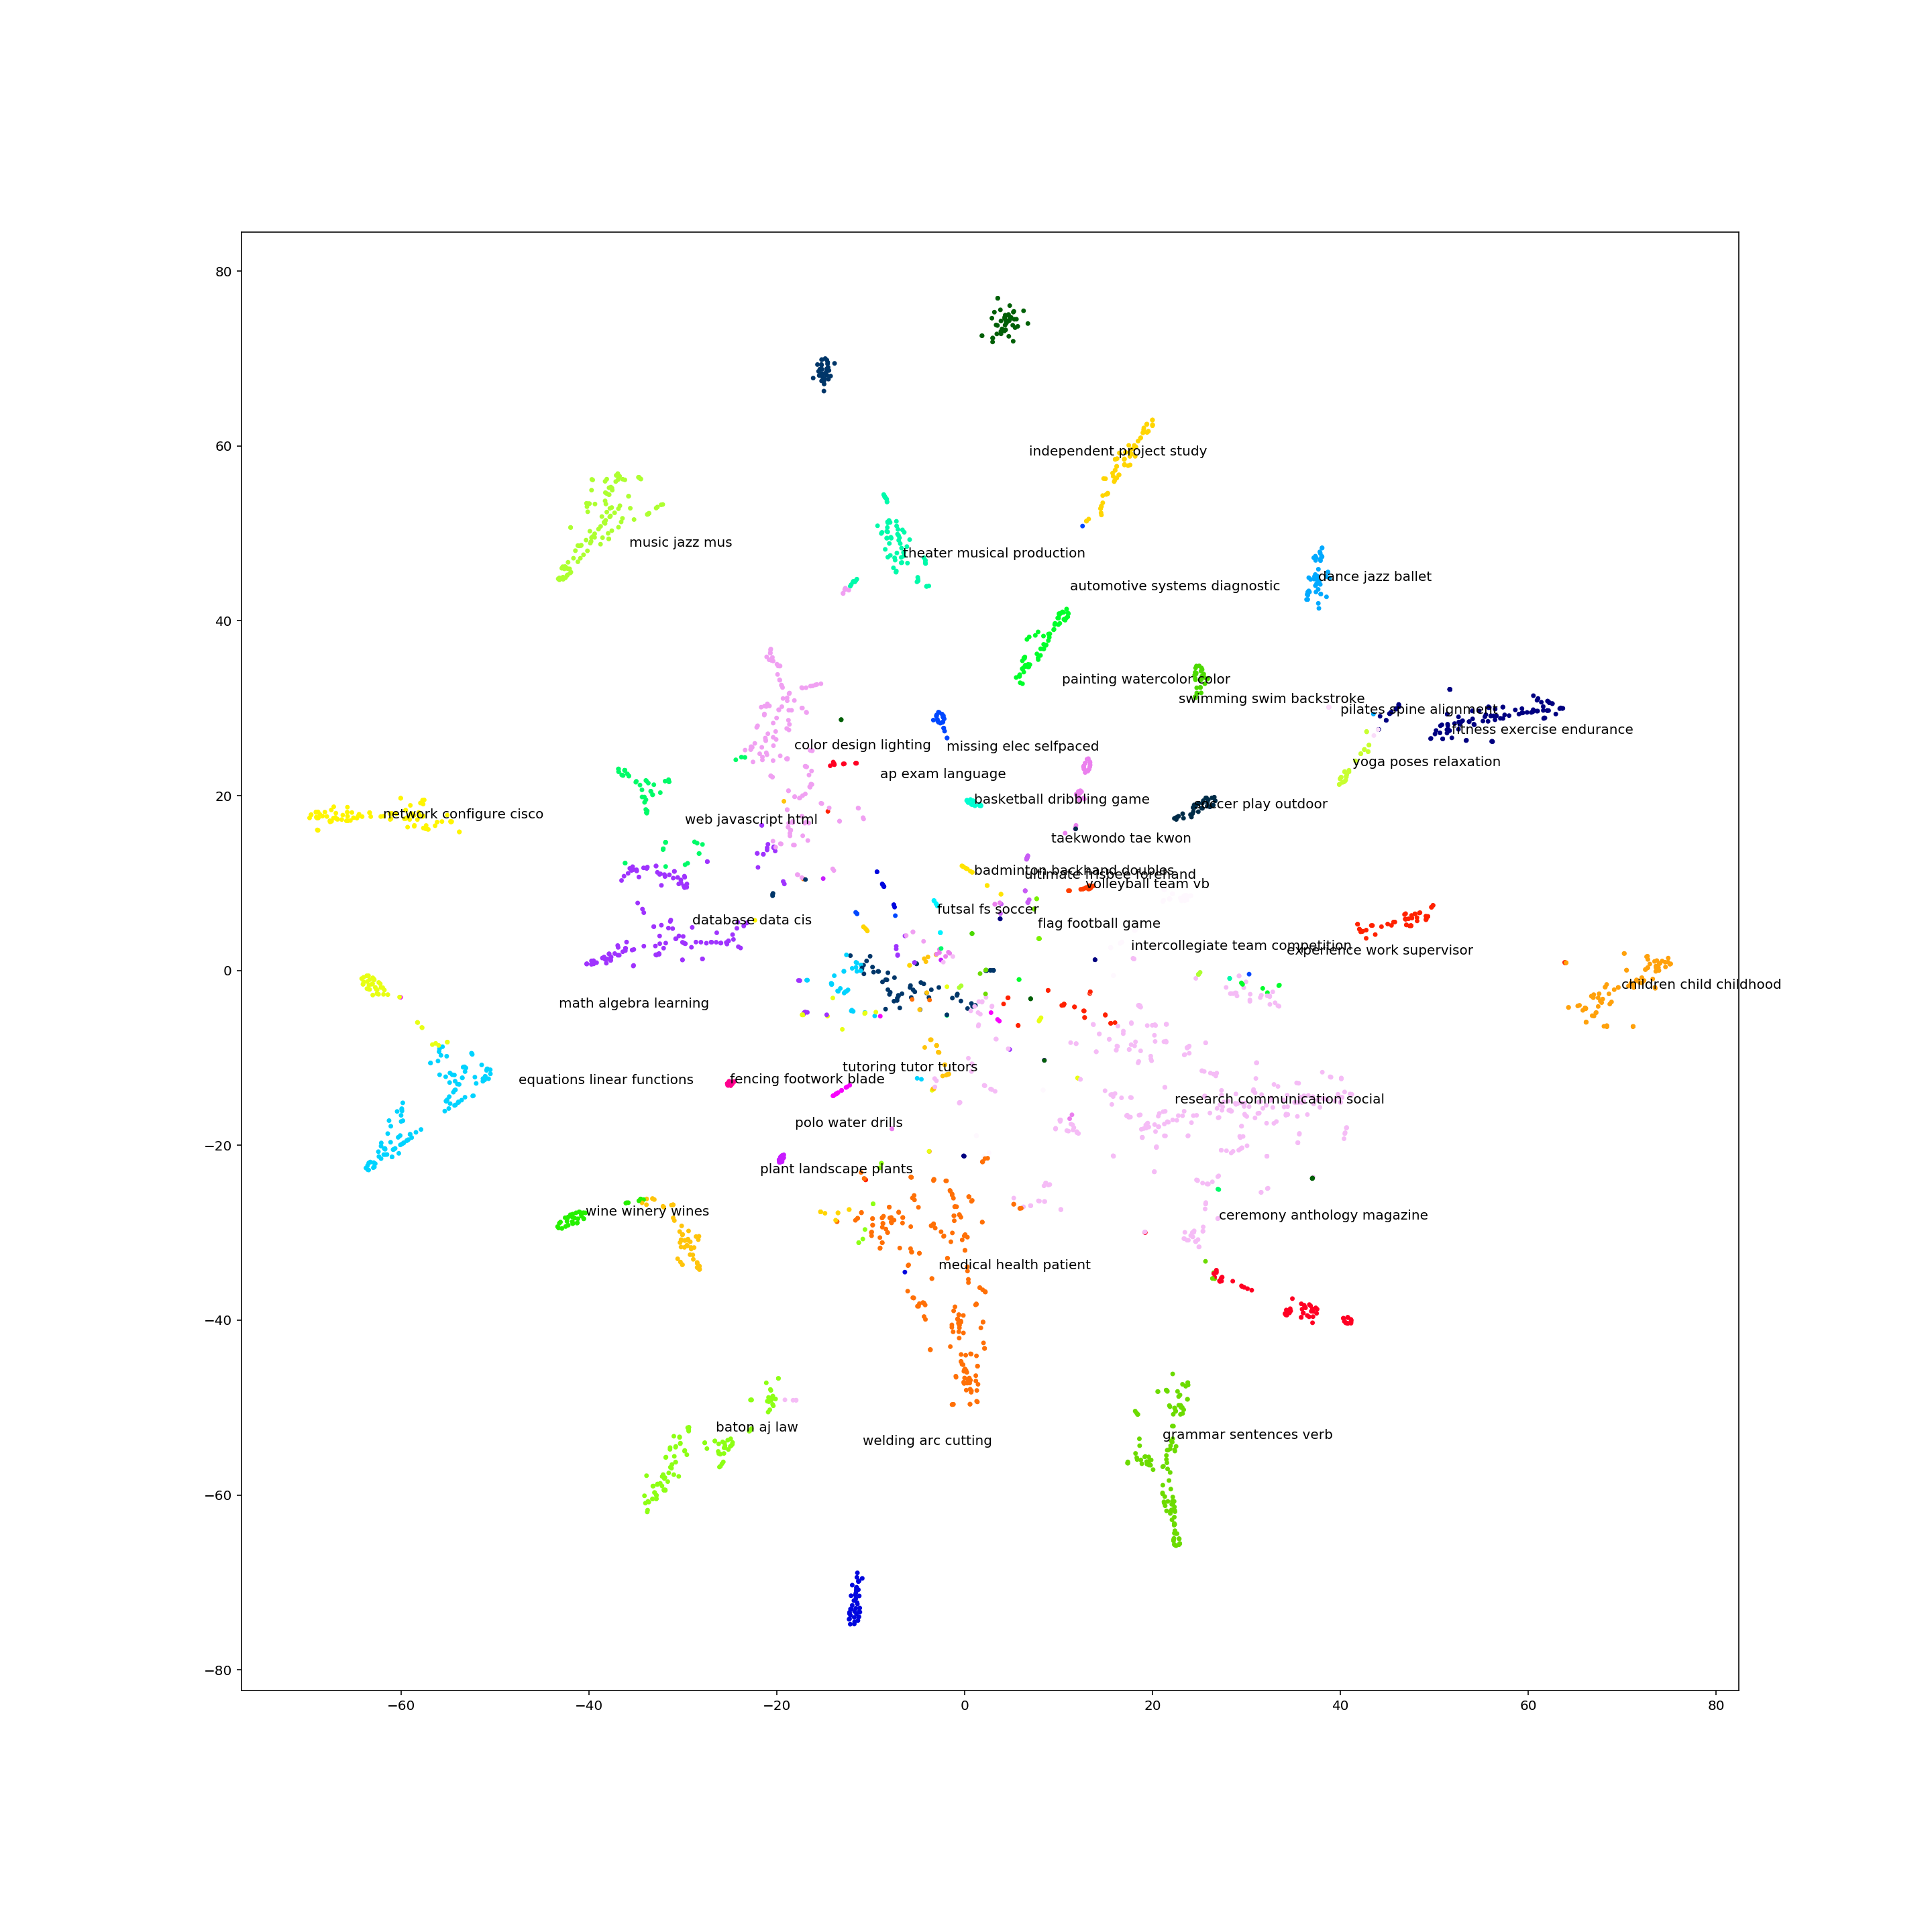

In [245]:
# fig = plt.figure(figsize=(20, 20))
# data = tsne_embedding
# scatter = plt.scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="gist_ncar")
# for i, words in enumerate(topic_words):
#     plt.annotate(words, (tsne_centers[i][0], tsne_centers[i][1]))
# plt.show()

In [389]:
tsne = TSNE(n_components=3, random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y','z'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)


In [390]:
tsne_groups = [[] for x in range(num_topics)] 
for i in range(len(tsne_embedding)):
    tsne_groups[tsne_embedding['hue'][i]].append((tsne_embedding['x'][i],tsne_embedding['y'][i],tsne_embedding['z'][i]))
tsne_centers = [center(points, d=3) for points in tsne_groups]
topic_numbers = list(range(num_topics))

In [391]:
from mpl_toolkits import mplot3d
%matplotlib notebook


fig3d = plt.figure('3d', figsize = (20, 20))
ax = plt.axes(projection='3d')

ax.scatter3D(tsne_embedding['x'], tsne_embedding['y'], tsne_embedding['z'],s=15, c=tsne_embedding['hue'], cmap='gist_ncar')
for i, num in enumerate(topic_numbers):
    ax.text(tsne_centers[i][0], tsne_centers[i][1], tsne_centers[i][2], num)

<IPython.core.display.Javascript object>

**Checking Topic Coherence Visually using Glove**

In [339]:
def get_vec(word):
    return utils.get_vec(word, utils.wordL, utils.array, utils.lengths)

In [392]:
word_embedding = np.array([get_vec(word)[0] for word in top_n_words(1)])

tsne_word_embedding = tsne.fit_transform(word_embedding)
tsne_word_embedding = pd.DataFrame(tsne_word_embedding,columns=['x','y'])

ValueError: Shape of passed values is (3, 30), indices imply (2, 30)

In [ ]:
tsne_word_embedding

In [375]:
from sklearn.decomposition import PCA

data = pd.DataFrame(PCA(n_components = 2).fit_transform(word_embedding),columns=['x','y'])

In [ ]:
# using first word to represent topic


fig = plt.figure(figsize=(15, 15))
data = tsne_word_embedding
topic_words = top_n_words(1)
scatter = plt.scatter(data=data,x='x',y='y',s=6,cmap="gist_ncar")
for i, words in enumerate(topic_words):
    plt.annotate(words, (data.values[i][0], data.values[i][1]))
plt.show()

**Reducing Dimension using SVD**

In [196]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd_embedding = svd.fit_transform(nmf_embedding)
svd_embedding = pd.DataFrame(svd_embedding,columns=['x','y'])
svd_embedding['hue'] = nmf_embedding.argmax(axis=1)

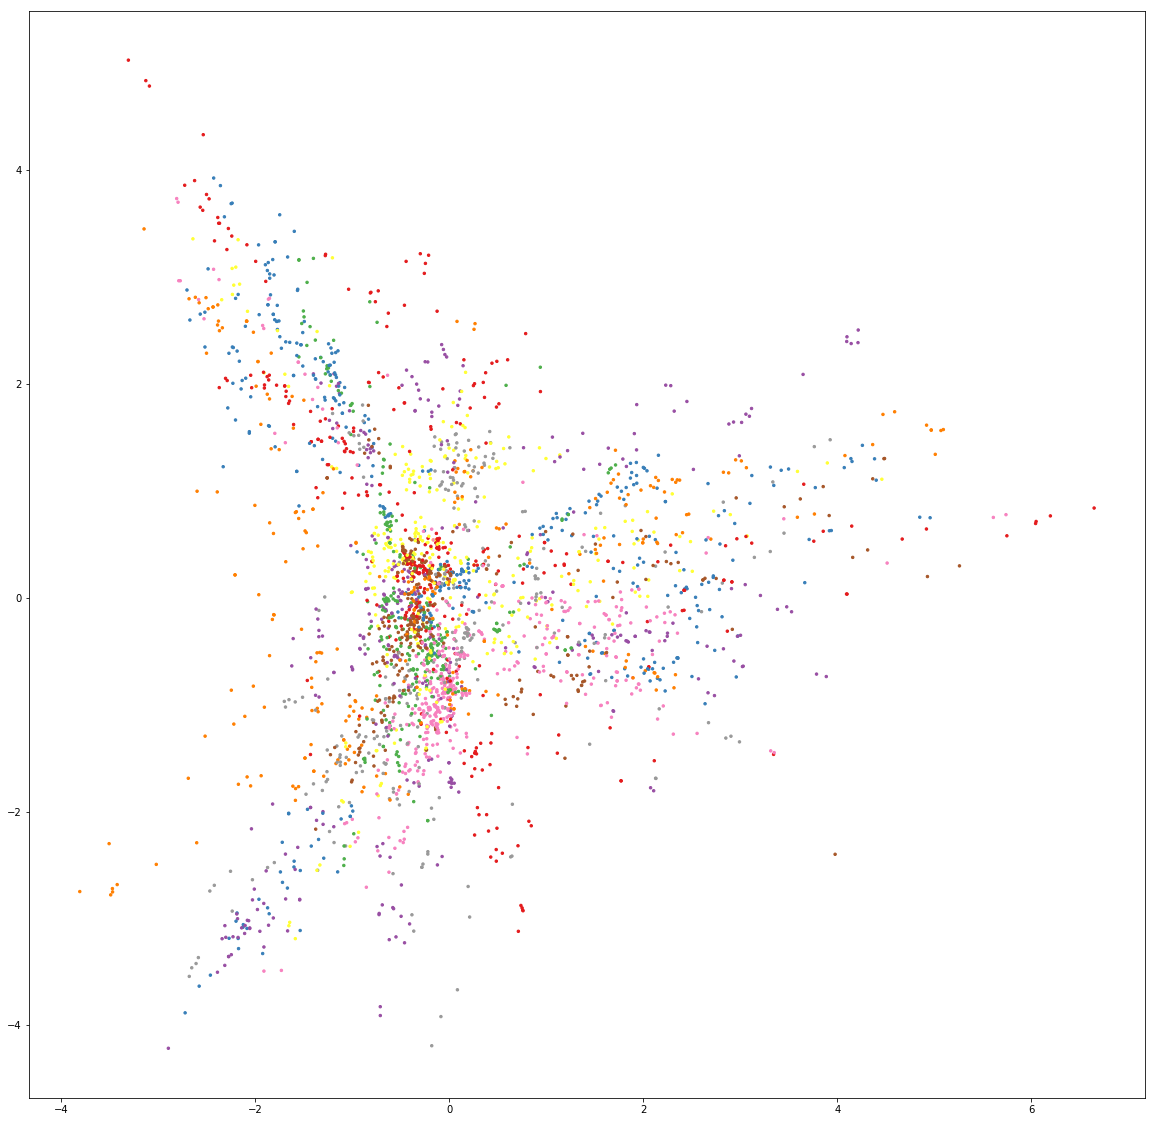

In [197]:
fig2 = plt.figure(figsize=(20, 20))
data = svd_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set1")

**LDA**

In [485]:
corpus_used = cleaned_corpus_1

In [486]:
id2word = gensim.corpora.Dictionary(corpus_used);
id2word

In [487]:
bow_corpus = [id2word.doc2bow(doc) for doc in corpus_used]

In [488]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [523]:
num_topics = 15

In [524]:
lda = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state = 42)

In [520]:
lda_tfidf = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics=num_topics, id2word=id2word, passes=5, random_state = 42)

In [425]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [526]:
get_lda_topics(lda, num_topics)

Topic # 01     Topic # 02  Topic # 03     Topic # 04  Topic # 05   Topic # 06  Topic # 07   Topic # 08    Topic # 09     Topic # 10     Topic # 11     Topic # 12     Topic # 13  Topic # 14     Topic # 15
0          math    development         lab        welding      course       design     reading       course          fire         course          music         health         course      course         course
1        linear         course      course         course      energy          use     writing        class        safety          class           work        medical          class    research         design
2         solve        lecture      system            lab     physics       create         use      student     equipment        student    performance        patient         soccer       class           work
3           may            lab     network          basic  laboratory       course     grammar   instructor     emergency       training         course         system           wine      social        project
4           use     psychology     lecture        explain   configure          web    identify          use       control  participation        student           care           exam       group  communication
5       algebra       behavior  laboratory          earth        data  development     present          may        course        typical     production     management        student     lecture          color
6        course         health        data       swimming         use     painting      simple      college      describe    demonstrate          class           body        lecture       study        student
7      homework         sexual    describe        typical      motion         data        verb         work        lesson       exercise        musical     assessment        college  discussion          class
8          work         theory         use          class     circuit       lesson        text       office    protection        fitness        theater        anatomy        explain     culture          group
9      function     discussion    security    demonstrate       field      project    sentence         week  construction            kin        typical       describe          world     student        lecture
10          lab     automotive    computer          water    analysis          lab       write      writing      identify            lab           jazz         course            may     history            lab
11  exponential  psychological     student        lecture     chapter      lecture        word         must           use     evaluation     literature        disease           play     discuss       business
12   instructor       describe        exam       geologic        work      drawing  vocabulary  information         water         proper        lecture          human       economic    cultural   presentation
13      student       research   structure        student     current     computer        past     academic    management    performance  participation      emergency       describe   political          study
14      lecture          class        cell      equipment         law         page      course     learning       lecture       strength           able     physiology    development    learning      effective
15     rational        student         may         system    electric     language    language         exam         basic    instruction    demonstrate      knowledge        typical         art            may
16     assigned        typical    identify            use       apply         work      speech         time      vineyard           body       lighting          blood     evaluation          th        typical
17       number         system   operating           swim         lab        basic         one  demonstrate      incident  demonstration        content       clinical        history  historical            use
18        class        explain    

In [521]:
get_lda_topics(lda_tfidf, num_topics)

Topic # 01    Topic # 02    Topic # 03    Topic # 04   Topic # 05       Topic # 06    Topic # 07    Topic # 08   Topic # 09      Topic # 10     Topic # 11     Topic # 12     Topic # 13       Topic # 14    Topic # 15       Topic # 16      Topic # 17     Topic # 18      Topic # 19      Topic # 20   Topic # 21    Topic # 22        Topic # 23    Topic # 24  Topic # 25     Topic # 26    Topic # 27    Topic # 28     Topic # 29     Topic # 30   Topic # 31     Topic # 32
0          linear     landscape     newspaper    automotive      physics         painting        guitar         color     swimming           dance       geologic        patient        writing           soccer          yoga            child         theater         design    anthropology      statistics      welding   independent          painting          polo  volleyball        theater       jujitsu         radio        network      lightroom         fire           verb
1           solve           war          news        engine    chemistry          acrylic        floral           gun         swim            body    illustrator        medical       sentence  intercollegiate     dictation        childhood    microbiology          music        religion         theater          arc          math             color         earth    ultimate       lighting          judo       station          cisco       abnormal   protection        grammar
2            math     political    television    diagnostic     chemical  electromagnetic          golf           tae       stroke         anatomy         dating           care        library       basketball       singing    developmental        swimming  communication       religious     probability        metal         study              drug     badminton    forehand     theatrical          flag     broadcast          rifle      treatment    emergency           past
3     exponential        client         story    misconduct    molecular       refraction     astronomy   photography   backstroke          weight         fossil       clinical        grammar             game    relaxation        cognitive      backstroke       business   philosophical       character         swat           due              west      geologic    backhand        costume      football  facilitation         patrol         mental    fieldwork          tense
4   trigonometric        gender    journalism     diagnosis   laboratory        orchestra     floristry       drawing    butterfly            jazz        geology      emergency     vocabulary      competition         sight            early         aquatic       training      philosophy         musical        crime       biology           acrylic         water       fungi             ti        market      lighting        missing       disorder     juvenile     participle
5         algebra      politics    production          auto  dimensional           optics       optical        figure         user          muscle    radiometric         health         please             play      harmonic       curriculum            swim     management            myth  presentational        steel       algebra               hue       martial       plant           crew        supply      tolerant  configuration       etiology    sprinkler           noun
6       quadratic        united     editorial        repair      circuit         hydrogen         solar        camera  competitive         medical    imagination           drug        reading        offensive       cutting  developmentally              ex    performance     archaeology       rehearsal     criminal       project     theoretically       geology       throw         scenic      economic    commercial        routing        carotid        alarm     infinitive
7     logarithmic            us           asp          fuel     electric          squeeze       funeral          kick       medley           heart         honest       pharmacy       academic        defensiv

In [525]:
vis_data =pyLDAvis.gensim.prepare(lda, bow_corpus, id2word)
pyLDAvis.display(vis_data)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


**Determine the optimal number of topics**

In [435]:
from itertools import combinations

In [436]:
def calculate_coherence(topics_df, top = 5):
    skipped_over = 0
    num_topics = topics_df.shape[1]
    print(num_topics)
    topics_df = topics_df.head(top) # how many words do we actually want to look at?
    overall_coherence = 0.0
    for column in topics_df:
        # check each pair of terms
        pair_scores = []
        for pair in combinations(topics_df[column], 2 ):
            if not pair[0] in utils.wordL or not pair[1] in utils.wordL:
                skipped_over += 1
                continue   # skip if not there 
            score = utils.score(pair[0], pair[1]) 
            pair_scores.append(score)
            if score > 1 or score < -1: 
                print("problem!")
                print(score)
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / num_topics, skipped_over

In [438]:
calculate_coherence(get_lda_topics(lda_tfidf, num_topics), 3)

50


(0.31790986787889325, 6)

In [439]:
topic_coh = []

In [502]:
for i in range(10, 80):
    lda_tfidf = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics=i, id2word=id2word, passes=5, random_state = 42)
    cohs = calculate_coherence(get_lda_topics(lda_tfidf, i), 3)[0]
    print(cohs)
    topic_coh.append(cohs)

10
0.29599552677531155
11
0.32100884508850586
12
0.3272643087988034


KeyboardInterrupt: 

In [493]:
topic_coh3 = []
for i in range(10, 80):
    lda_tfidf = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics=i, id2word=id2word, passes=5, random_state = 42)
    coh = calculate_coherence(get_lda_topics(lda_tfidf, i), 3)[0]
    print(coh)
    topic_coh3.append(coh)

10
0.42778439193966095
11
0.4641284475387702
12
0.4451715487318433
13
0.46710169246990474
14
0.4519003030391925
15
0.48097252378767347
16
0.4413076233184559
17
0.465221896036286
18
0.45466665472528356
19
0.4552666542069625
20
0.44946149625726306
21
0.44446979205189296
22
0.4485925974862065
23
0.43448156475310684
24
0.4689804590729784
25
0.4590129034978012
26
0.4610413418876672
27
0.4356533002555913
28
0.46140478492978715
29
0.47445878583486967
30
0.47247717779042
31
0.4603793153946909
32
0.4691544322194809
33
0.44228520128955257
34
0.47195052998086656
35
0.45216471413859444
36
0.4465064964150629
37
0.4548062974322712
38
0.4548318687698922
39
0.46544847937965944
40
0.4451486470575299
41
0.45023755990082637
42
0.4309705243589053
43
0.4514498651904697
44
0.43387901022592046
45
0.4474455587371806
46
0.4237152391166526
47
0.43495360139302414
48
0.44471808421546816
49
0.4373652197429074
50
0.4297683467217611
51
0.4643684189326822
52
0.445399016930692
53
0.43106339445989694
54
0.4615396561637

In [ ]:
topic_coh

<IPython.core.display.Javascript object>


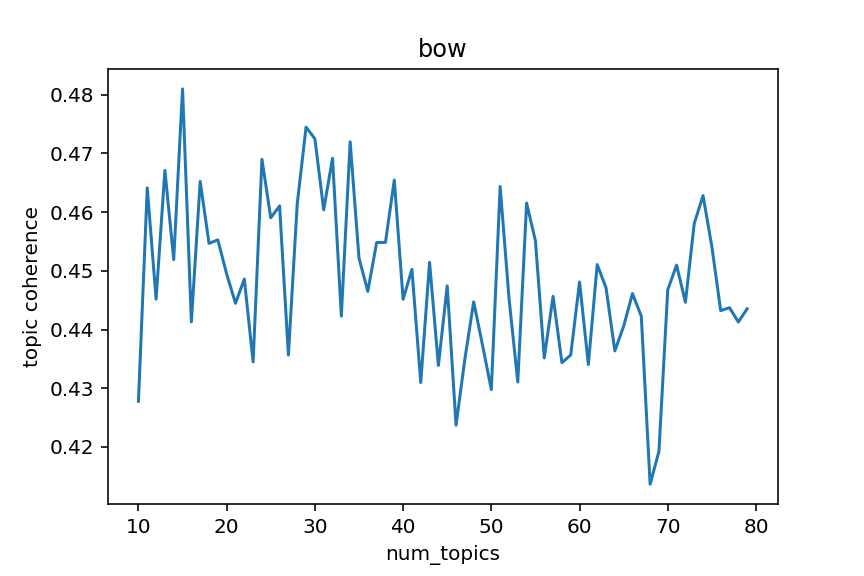

In [518]:
plt.figure(0)
plt.title('bow')
plt.xlabel('num_topics')
plt.ylabel('topic coherence')
plt.plot(list(range(10,80)), topic_coh3)
plt.savefig('LDA_bow_coherence')

In [507]:
len(topic_coh[30:100])

70

In [498]:
len(topic_coh)

100

<IPython.core.display.Javascript object>


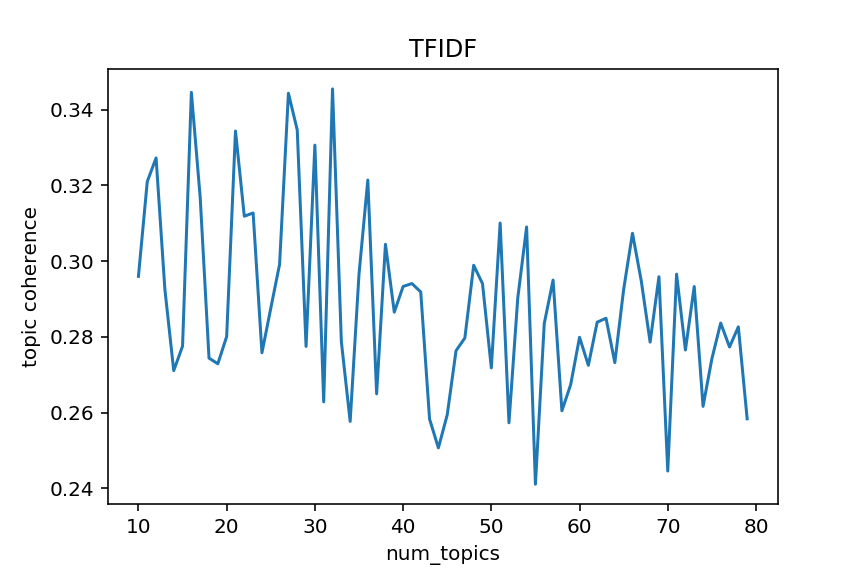

In [516]:
plt.figure()
plt.title('TFIDF')
plt.xlabel('num_topics')
plt.ylabel('topic coherence')
plt.plot(list(range(10,80)), topic_coh[30:100])
plt.savefig('LDA_tfidf_coherence')

**HDP**

In [113]:
from gensim.models import HdpModel

In [114]:
def get_hdp_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [115]:
hdp = gensim.models.hdpmodel.HdpModel(bow_corpus, id2word=id2word)

In [116]:
hdp_tfidf = gensim.models.hdpmodel.HdpModel(corpus_tfidf, id2word=id2word)

In [72]:
get_hdp_topics(hdp, 10)

Topic # 01   Topic # 02     Topic # 03     Topic # 04   Topic # 05  \
0        course       course         course         course       course   
1         class          use        student           fire          use   
2       student      student          class          class        color   
3       lecture          lab        lecture        student      lecture   
4          work        class          group            lab        class   
5          fire         work            use        lecture         work   
6           may       design           work            use      student   
7       typical      lecture       research        typical          lab   
8           use          may        typical            may      typical   
9           lab      typical            may    demonstrate     identify   
10      college      reading  communication           able       design   
11     describe          web        college    development      reading   
12     research         able            lab       training          may   
13  development       create            one         system  demonstrate   
14        group   instructor    development     evaluation         able   
15   discussion   evaluation           able          basic      grammar   
16     identify        basic       identify  participation       simple   
17   management      college     discussion      effective   evaluation   
18         able  demonstrate      effective       identify     learning   
19   evaluation       linear     evaluation    instruction      writing   

     Topic # 06     Topic # 07    Topic # 08       Topic # 09     Topic # 10  
0        course         course    statistics  intercollegiate      anthology  
1         class            lab        course             team       ceremony  
2       student           math      standard           course       literary  
3          work          class          data         practice         layout  
4      painting        lecture   probability      competition       magazine  
5       musical        welding           use            class    publication  
6       lecture            use          mean      demonstrate         design  
7       theater        testing  distribution      performance        student  
8   performance       learning          find             game         course  
9       typical        algebra       typical    participation        lecture  
10          art        student           lab              kin           work  
11        music     management       lecture       individual          group  
12      content         system          math            daily         format  
13         able       vineyard     deviation            water            lab  
14          lab  understanding         basic              lab          staff  
15         film           test    hypothesis             polo         create  
16          use        typical           may          typical  participation  
17  demonstrate       identify      variance       basketball        digital  
18   evaluation       relevant        normal         training     production  
19        group        control         class          college         assess

In [118]:
get_hdp_topics(hdp_tfidf, 15)

Topic # 01 Topic # 02      Topic # 03     Topic # 04     Topic # 05  \
0          design       fire         grammar        fitness        mestiza   
1             web        kin         writing       exercise   professional   
2        business   swimming        coverage        crowded       softball   
3          linear   describe            verb          seven      matchable   
4            math       wine    encroachment          grand           polo   
5           color      child         musical         search     monohybrid   
6        learning      dance           tense           rate     permission   
7          soccer       head        dominant       muscular     volleyball   
8           music       swim           brown      endurance        colored   
9        academic      early          ballad      correctly   patternmaker   
10           data      birth          fowler  acculturation     pyrolusite   
11         office     energy  simplification          agree       twisting   
12           page       life           board          keyed           soul   
13  communication     plaque      resolution         lyceum  demonstration   
14           exam  childhood   prepositional       strength        shakers   
15     management   training            word     hydrologic   cryptography   
16         system     system         octopus       football         design   
17       painting    fitness          acting        aerobic       securely   
18    performance    lockout  lateralization           neal          spree   
19     instructor     social      epiglottis           howl      plausible   

        Topic # 06     Topic # 07    Topic # 08     Topic # 09    Topic # 10  \
0           jungle         desire  construction        nervous    horizontal   
1         skimming        thyroid    vocational   neuroanatomy  aggressively   
2         wearable            set     handwrist     litigation         deuce   
3   categorization     assimilate           fly          tutor        phrase   
4             gift            owl         waltz       synovial    poignantly   
5              ink       endorsed   nonacademic      nonverbal      typology   
6        intestine       paranoid     osteology     screenplay     dosimetry   
7        following  certification    planktonic       meridian          hell   
8    procrastinate       polarity  departmental    predictably  definitional   
9   stereochemical            vat      lukewarm    wearability     agreement   
10       diversity         tissue           tae          sport         ratio   
11    relationship      adulthood     enclosure     periodical         carry   
12      reassembly    exclusively         stuck           alba      category   
13          glance           alto         perry     understand         write   
14      protection  micronutrient    barometric        oceanic        people   
15        weakness        pertain           fin           otto       airable   
16      chauvinism          novel       classic  commercialism      tomorrow   
17    constitution           leer        rubber         factor       mystery   
18        directed     rotational       dieback         dialer         sleet   
19       fattiness          awake      directly         regent         dutch   

       Topic # 11            Topic # 12           Topic # 13       Topic # 14  \
0        thirteen                  bios  otorhinolaryngology           nekton   
1        turnover              withheld           generalist         bathroom   
2          invent           terminology        neuromuscular       preclassic   
3      assemblage                always          psychomotor         overhead   
4          eighth             patricide        orthogonality               om   
5          triton               atomics        recirculation          causing   
6           slice                   lan                 chad  constructionist   
7           clear             generally

Hierarchical Dirichlet Process doesn't seem to work very well 